## 图像2，4，16等分

### 16等分

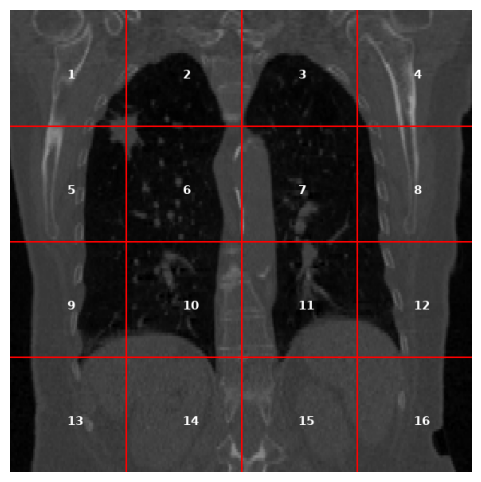

In [14]:
# Import necessary libraries for displaying inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Load the sixth image
sixth_image_path = "/mnt/dataset/ouyang/dataset/579/POPI_seq3_2D_579/2DCT-6/90.png"
image = Image.open(sixth_image_path)

# Create draw object to add labels
draw = ImageDraw.Draw(image)

# Font settings (default PIL font)
# font = ImageFont.load_default()
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 15)

# Line color and thickness
line_color = "red"
line_thickness = 2

# Get image dimensions (assuming the same 4x4 grid as previous)
width, height = image.size

# Recalculate the correct cell width and height for equal division
cols, rows = 4, 4
cell_width = width // cols
cell_height = height // rows

# Draw red dividing lines (vertical and horizontal) to ensure equal division
for col in range(1, cols):
    x = col * cell_width
    draw.line([(x, 0), (x, height)], fill=line_color, width=line_thickness)

for row in range(1, rows):
    y = row * cell_height
    draw.line([(0, y), (width, y)], fill=line_color, width=line_thickness)

# Add the numbers again to the cells
for row in range(rows):
    for col in range(cols):
        x = col * cell_width
        y = row * cell_height
        text_x = x + cell_width // 2
        text_y = y + cell_height // 2
        draw.text((text_x, text_y), str(row * cols + col + 1), font=font, fill="white")

# Display the corrected image with equal divisions and labels
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

### 2等分

* 上下

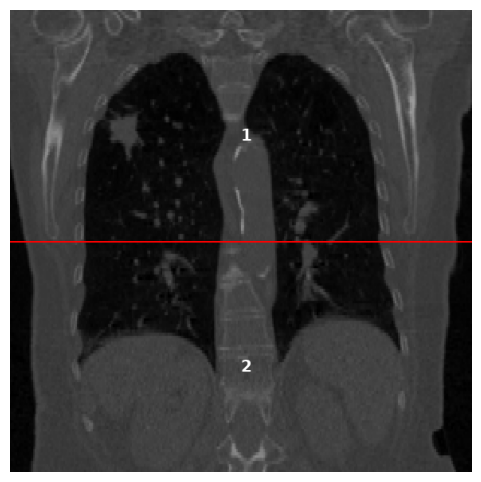

In [7]:
# Import necessary libraries for displaying and manipulating images
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Line color and thickness settings
line_color = "red"
line_thickness = 2

# Font settings (default PIL font)
# font = ImageFont.load_default()
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)

# Load the image for 2-part division
image_path = "/mnt/dataset/ouyang/dataset/579/POPI_seq3_2D_579/2DCT-6/90.png"
image = Image.open(image_path)

# Get image dimensions
width, height = image.size

# Calculate the half height for 2 equal horizontal parts
half_height = height // 2

# Create draw object for the image
draw = ImageDraw.Draw(image)

# Draw one horizontal red line to divide the image into 2 equal parts
draw.line([(0, half_height), (width, half_height)], fill=line_color, width=line_thickness)

# Add the labels for the two parts
draw.text((width // 2, half_height // 2), "1", font=font, fill="white")
draw.text((width // 2, half_height + half_height // 2), "2", font=font, fill="white")

# Display the image with the 2 equal parts
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

* 左右

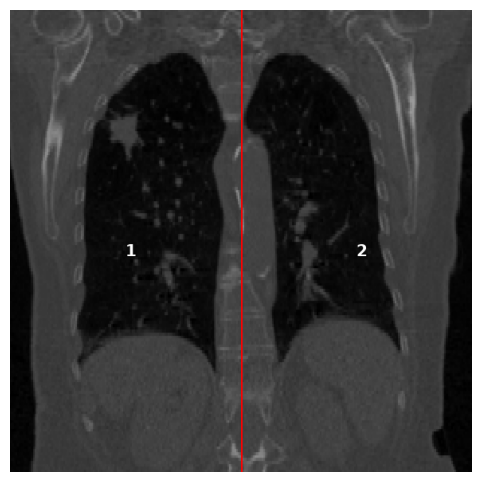

In [9]:
# Import necessary libraries for displaying and manipulating images
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Line color and thickness settings
line_color = "red"
line_thickness = 2

# Font settings (default PIL font)
# font = ImageFont.load_default()
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)

# Load the image for 2-part division
image_path = "/mnt/dataset/ouyang/dataset/579/POPI_seq3_2D_579/2DCT-6/90.png"
image = Image.open(image_path)

# Get image dimensions
width, height = image.size

# Calculate the half height for 2 equal horizontal parts
half_width = width // 2

# Create draw object for the image
draw = ImageDraw.Draw(image)

# Draw one horizontal red line to divide the image into 2 equal parts
draw.line([(half_width, 0), (half_width, height)], fill=line_color, width=line_thickness)

# Add the labels for the two parts
draw.text((half_width // 2, height // 2), "1", font=font, fill="white")
draw.text((half_width + half_width // 2, height // 2), "2", font=font, fill="white")

# Display the image with the 2 equal parts
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

### 4分割

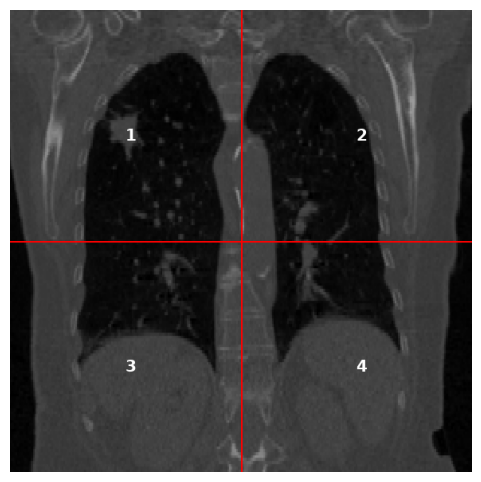

In [18]:
# Import necessary libraries for displaying and manipulating images
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Line color and thickness settings
line_color = "red"
line_thickness = 2

# Load the new image for 4-part division
image_path = "/mnt/dataset/ouyang/dataset/579/POPI_seq3_2D_579/2DCT-6/90.png"
image = Image.open(image_path)

# Get image dimensions
width, height = image.size

# Calculate the half width and height for 4 equal parts (2x2 grid)
half_width = width // 2
half_height = height // 2

# Load a specific font and set a larger size for labels
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)

# Create draw object for the image
draw = ImageDraw.Draw(image)

# Draw two red lines: one vertical and one horizontal to divide into 4 parts
draw.line([(half_width, 0), (half_width, height)], fill=line_color, width=line_thickness)
draw.line([(0, half_height), (width, half_height)], fill=line_color, width=line_thickness)

# Add the labels for the four parts with the new font size
draw.text((half_width // 2, half_height // 2), "1", font=font, fill="white")
draw.text((half_width + half_width // 2, half_height // 2), "2", font=font, fill="white")
draw.text((half_width // 2, half_height + half_height // 2), "3", font=font, fill="white")
draw.text((half_width + half_width // 2, half_height + half_height // 2), "4", font=font, fill="white")

# Display the image with the 4 equal parts
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Hide axis
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove the white border
plt.show()

## BOX PLOT

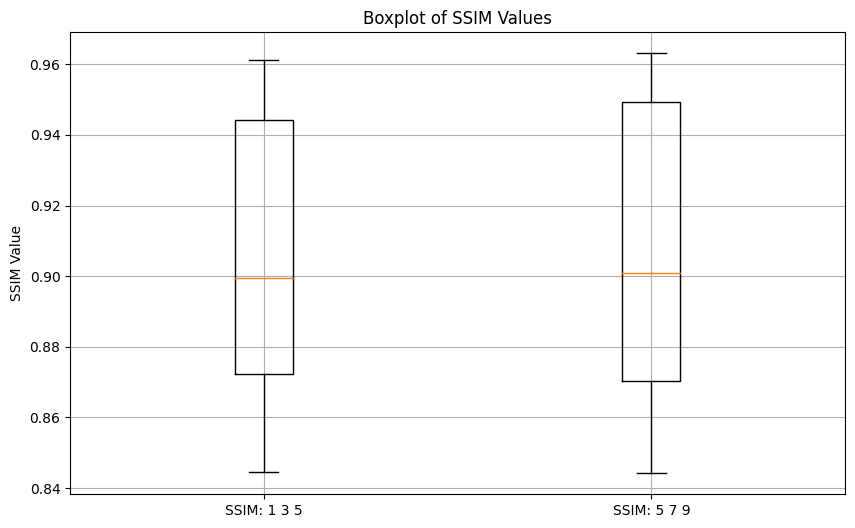

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566],
    'SSIM: 0 2 4': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 4 6 8': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583]
}

df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

# Now we plot the boxplot using the DataFrame
plt.figure(figsize=(10, 6))
plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 5 7 9']])
plt.xticks([1, 2], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 2 4 6': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583],
    'SSIM: 6 8 10': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566]
}
df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

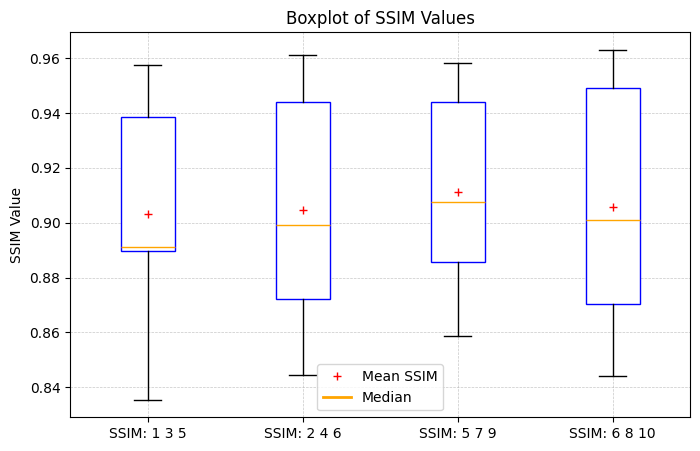

In [2]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 2 4 6'], df['SSIM: 5 7 9'], df['SSIM: 6 8 10']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0.6,1)

# Show the plot with mean points indicated
plt.show()

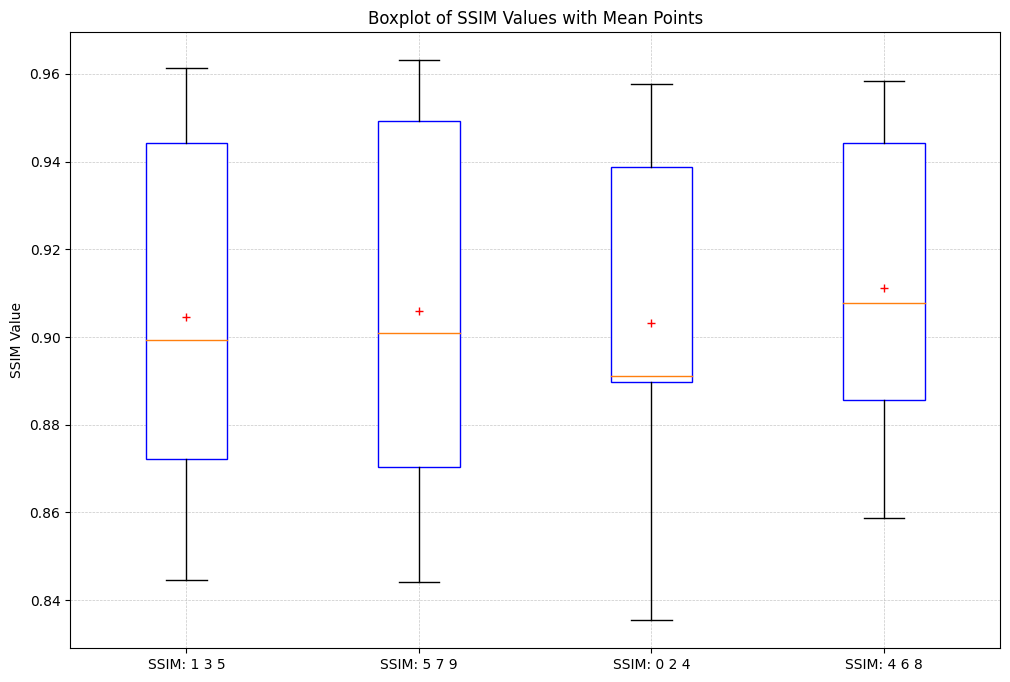

In [55]:
# Correcting the x-ticks to show all four columns of data
plt.figure(figsize=(12, 8))

# Creating the boxplot with mean points for the new data with all four columns
boxplot_elements = plt.boxplot([df[col] for col in df.columns],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles with all four SSIM values
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.title('Boxplot of SSIM Values with Mean Points')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

## 比較BOXPLOT

### SSIM 结果

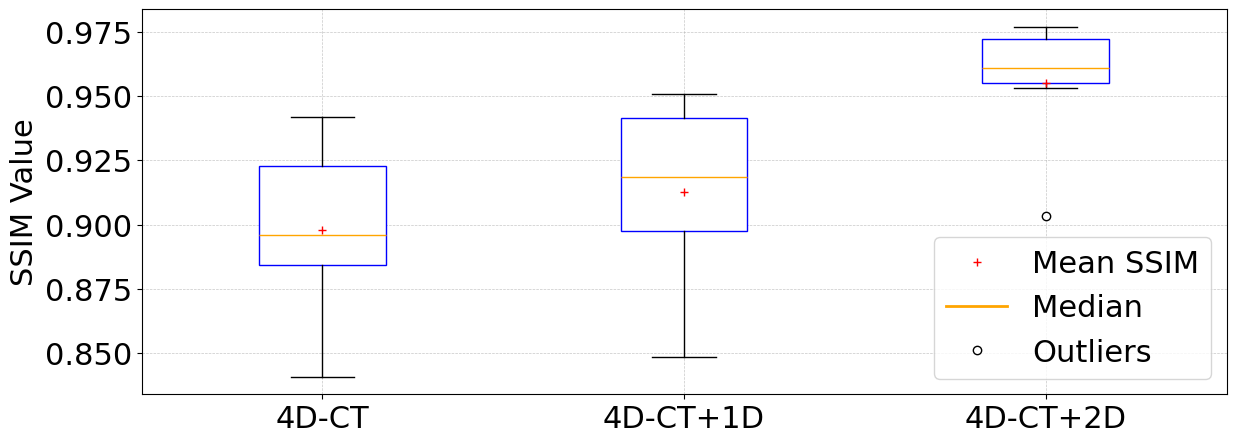

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # LE_sever_result
    # '4D-CT': [0.8627, 0.771, 0.8858, 0.8523, 0.9182, 0.9109],
    # '4D-CT+1D': [0.8856, 0.7908, 0.9016, 0.8709, 0.9261, 0.9189],
    # '4D-CT+2D': [0.92975, 0.846, 0.934, 0.923, 0.9525, 0.9475] # epoch 200 

    # AWS_result
    '4D-CT': [0.8822, 0.8408, 0.9012, 0.8904, 0.9419, 0.9297],
    '4D-CT+1D': [0.8923, 0.8484, 0.9126, 0.9244, 0.9508, 0.9469],
    '4D-CT+2D': [0.9531, 0.9032, 0.9606, 0.9609, 0.9769, 0.976] # epoch 200 
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(14, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 22})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT'], df['4D-CT+1D'], df['4D-CT+2D']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:], fontsize=22)
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value', fontsize = 22)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0.7,1)

# Show the plot with mean points indicated
plt.show()

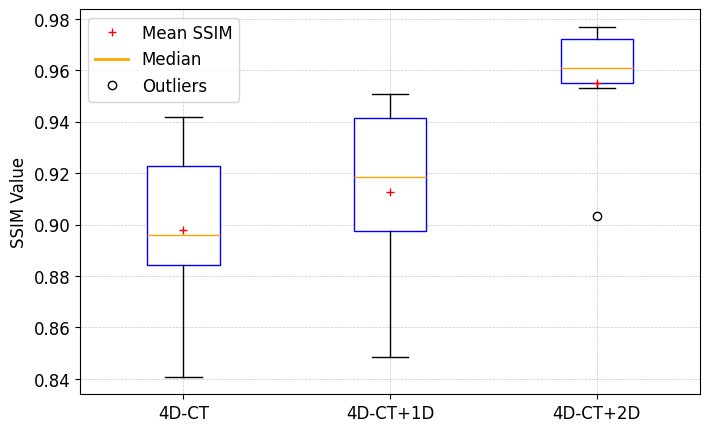

In [2]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT'], df['4D-CT+1D'], df['4D-CT+2D']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

### PSNR结果

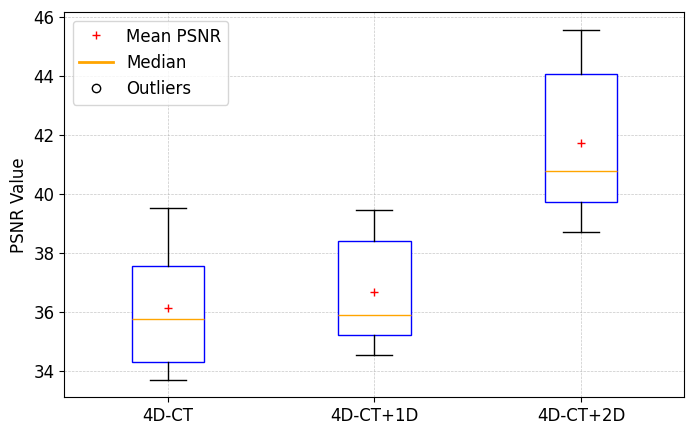

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # LE_sever_result
    # '4D-CT': [36.5957, 34.9455, 33.9995, 33.7551, 39.6594, 37.6953],
    # '4D-CT+1D': [35.6282, 33.1064, 34.3769, 34.6647, 39.2639, 37.7497],
    # '4D-CT+2D': [41.4611, 39.574, 38.6543, 39.5339, 45.6676, 44.3769] # epoch 200 

    # AWS_result
    '4D-CT': [36.5587, 34.9287, 33.6868, 34.0656, 39.5059, 37.8921],
    '4D-CT+1D': [35.5904, 35.0897, 34.5237, 36.1634, 39.4361, 39.1281],
    '4D-CT+2D': [41.5291, 39.6357, 38.6815, 39.9895, 45.5501, 44.9109] # epoch 200 
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT'], df['4D-CT+1D'], df['4D-CT+2D']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('PSNR Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean PSNR')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

### MAE结果

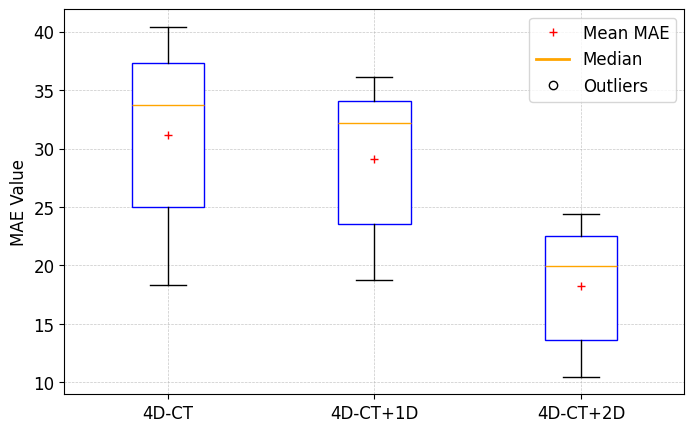

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    # LE_sever_result
    # # 服务器结果没有4DCT的结果 '4D-CT': [0.8627, 0.771, 0.8858, 0.8523, 0.9182, 0.9109],
    # '4D-CT+1D': [32.3524, 44.6685, 38.1656, 39.5160, 21.1077, 25.01],
    # '4D-CT+2D': [26.5125, 37.1074, 31.5373, 36.851, 17.4625, 21.2449] # epoch 200 

    # AWS_result
    '4D-CT': [30.2846, 37.1926, 37.4137, 40.4198, 18.3124, 23.2163],
    '4D-CT+1D': [32.1575, 36.1453, 34.6678, 32.2104, 18.7824, 20.6584],
    '4D-CT+2D': [18.0989, 24.4083, 21.8663, 22.7102, 10.4799, 12.1089] # epoch 200 
}
df = pd.DataFrame(data)
# df.set_index('Fold', inplace=True)

# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# 全局设置字体大小
plt.rcParams.update({'font.size': 12})

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')
flierprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6) # Outlier

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['4D-CT'], df['4D-CT+1D'], df['4D-CT+2D']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops,
                              
                               # whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据，解除将异常值视为正常数据
                               flierprops=flierprops # 异常值设定
                               # showfliers=False # 解除可以不显示异常值
                               )

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
# plt.title('Boxplot of SSIM Values')
plt.ylabel('MAE Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean MAE')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.plot([], [], 'o', markerfacecolor='white', markeredgecolor='black', label='Outliers', markersize=6)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0,1)

# Show the plot with mean points indicated
plt.show()

## 正常数据包含异常值

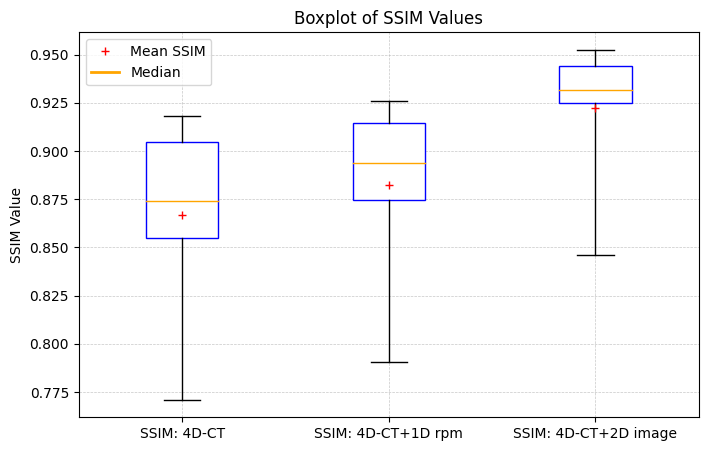

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 创建数据框架
data = {
    'SSIM: 4D-CT': [0.8627, 0.771, 0.8858, 0.8523, 0.9182, 0.9109],
    'SSIM: 4D-CT+1D rpm': [0.8856, 0.7908, 0.9016, 0.8709, 0.9261, 0.9189],
    'SSIM: 4D-CT+2D image': [0.92975, 0.846, 0.934, 0.923, 0.9525, 0.9475]
}
df = pd.DataFrame(data)

# 计算新的Q1为每列的最小值
new_q1 = df.min()

# 修改箱形图的whis参数，使得Q1设置为数据的最小值
plt.figure(figsize=(8, 5))

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df[col] for col in df.columns], # [df['SSIM: 4D-CT'], df['SSIM: 4D-CT+1D rpm'], df['SSIM: 4D-CT+2D image']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,

                               # 展示Mean 
                               showmeans=True,
                               meanprops=meanpointprops,

                               whis=(0, 100),  # 设置whis参数为(0, 100)以包含所有数据
                               boxprops=dict(linestyle='-', linewidth=1, color='blue'),
                               medianprops=dict(color="orange", linewidth=1))

# 为箱形图填充颜色
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.legend()

# 显示绘图
plt.show()